In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

In [14]:
def load_data(image_size, labels, base_path):
    X = []
    Y = []
    for label in labels:
        folderPath = os.path.join(base_path, label)
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            try:
              img = cv2.imread(img_path)
              img = cv2.resize(img, (image_size, image_size))
              X.append(img)
              Y.append(labels.index(label))
            except Exception as e:
              print(f"Error loading {img_name}: {e}")
    return X, Y
    # return np.array(X), np.array(Y)

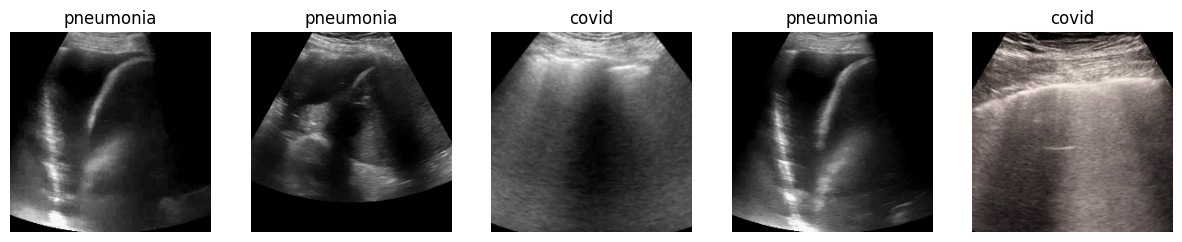

In [13]:
def display_random_images(X, Y, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        idx = random.randint(0, len(X) - 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx])
        plt.title(labels[Y[idx]])
        plt.axis('off')
    plt.show()

# Example usage
labels = ['covid', 'pneumonia']
base_path = '/content/drive/MyDrive/covid_pneumonia'  # Replace with your dataset path
image_size = 224

X, Y = load_data(image_size, labels, base_path)
display_random_images(X, Y, labels, num_images=5)

In [20]:
X = np.array(X, dtype='float32') / 255.0  # Normalize pixel values (0-1)
Y = np.array(Y)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

In [28]:
def build_and_train_model(base_model, X_train, Y_train, X_test, Y_test, labels, model_name):
    # Custom top layers
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    start_time = time.time()

    history = model.fit(
    train_datagen.flow(X_train, Y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, Y_test),
    workers=4,  # Number of CPU cores for data loading
    use_multiprocessing=True,  # Enables multiprocessing for faster data loading
    max_queue_size=10  # Controls the size of the data loading queue
    )


    training_time = time.time() - start_time

    plt.figure(figsize=(14, 7))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    model.save(f'lungultrasound_model_{model_name}.h5')

    # Confusion Matrix and Classification Report
    Y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

    conf_matrix = confusion_matrix(Y_test, Y_pred)
    class_report = classification_report(Y_test, Y_pred, target_names=labels)

    print(f'Classification Report for {model_name}:')
    print(class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Evaluate test loss and accuracy
    test_loss, test_accuracy = model.evaluate(X_test, Y_test)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Calculate test error as (1 - test_accuracy)
    test_error = 1 - test_accuracy
    print(f"Test Error: {test_error:.4f}")


    return history, training_time, conf_matrix, class_report, Y_test, Y_pred

In [ ]:
# Train ResNet50 Model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
history_resnet, time_resnet, conf_matrix_resnet, report_resnet, Y_test_resnet, Y_pred_resnet = build_and_train_model(base_model_resnet, X_train, Y_train, X_test, Y_test, labels, 'ResNet50')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/28 ━━━━━━━━━━━━━━━━━━━━ 8:03 28s/step - accuracy: 0.6302 - loss: 4.2494